In [10]:
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from growth.sweep.sweep import Sweep
from clones.visualization.settings import *
%matplotlib inline

In [4]:
figsize = (2, 2)
savedir = '../../../figures/graphics/synthetic_example/'
savefig = lambda fig, name: fig.savefig(join(savedir, '{:s}.pdf'.format(name)), dpi=400, 
                                        rasterized=True, transparent=True, bbox_inches='tight')

# Generate synthetic data

Load simulated bleedthrough control experiment and generate synthetic fluorescence data. Synthetic images contain three color channels:
   - BLUE: Nuclear stain
   - RED: Clonal marker
   - GREEN: Control reporter

In [6]:
sweep = Sweep.load('../../../data/synthetic/sweeps/Sweep_181201_191516_local//')
simulation = sweep[0]

In [11]:
# generate synthetic data
measurement_kwargs = dict(measurement_noise=0.)
microscopy_kwargs = dict(bg_level=0.2, bg_noise=0.3)

microscopy = simulation.generate_microscopy(ambiguity=0.25, rho=0.0, bleedthrough=0.5, 
                measurement_kwargs=measurement_kwargs, microscopy_kwargs=microscopy_kwargs)


# load existing synthetic data
microscopy.im = np.load('../../../data/synthetic/annotation_example/image.npy')
microscopy.data = pd.read_hdf('../../../data/synthetic/annotation_example/data.hdf', key='microscopy')

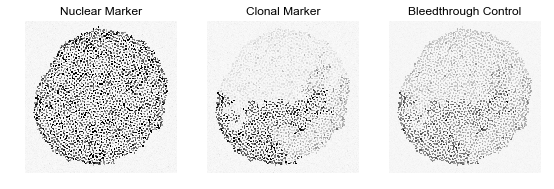

In [12]:
nuclear_marker = microscopy[0]
clonal_marker = microscopy[1]
control_reporter = microscopy[2]

fig = microscopy.render_panels(size=3)

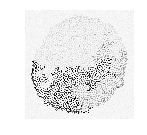

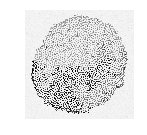

In [13]:
fig0 = clonal_marker.render(cmap=plt.cm.Greys)
fig1 = control_reporter.render(cmap=plt.cm.Greys)

#savefig(fig0, 'clonal_marker')
#savefig(fig1, 'control')

# Bleed-through control

In [14]:
from clones.bleedthrough.correction import Correction

x = microscopy.measure(1)
y = microscopy.measure(2)
bg_x = microscopy.extract_background_pixels(channel=1)
bg_y = microscopy.extract_background_pixels(channel=2)
correction = Correction(x, y, bg_x, bg_y, resample=True)

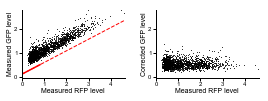

In [15]:
correction.show_correction(figsize=(4.25, 1.25))

#savefig(correction.figs['correction'], 'bleed_correction')

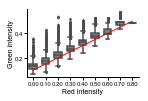

In [16]:
correction.show_fit(bin_size=0.1, figsize=(2, 1.25))

#savefig(correction.figs['fit'], 'bleed_fit')

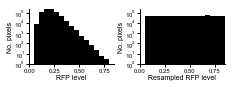

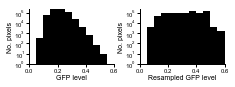

In [17]:
xbins = np.arange(0.05, .9, .05)
ybins = np.arange(0.05, 0.65, .05)
fig0, fig1 = correction.show_resampling(xbins=xbins, ybins=ybins, rasterized=True)

#savefig(fig0, 'bleed_red_resampling')
#savefig(fig1, 'bleed_green_resampling')

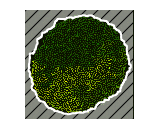

In [18]:
from clones.bleedthrough.background import BackgroundExtraction
from clones.visualization.masking import Mask
from copy import deepcopy

fg_mask = BackgroundExtraction.dilate_foreground(microscopy.foreground_mask, niters=10)

fig, ax = plt.subplots(figsize=figsize)

# extract and visualize red/green channels
rg = deepcopy(microscopy.rgb_im)
rg[:,:,-1] = 0
ax.imshow(rg)
ax.invert_yaxis()

# add foreground mask
mask = Mask(~fg_mask)
mask.add_contourf(ax, alpha=0.5, hatches=['//'])
mask.add_contour(ax, lw=2, color='w')
_ = ax.axis('off')

#savefig(fig, 'background_mask')

# Compare clones

In [20]:
microscopy.data['rfp_measured'] = x
microscopy.data['gfp_measured'] = y
microscopy.data['gfp_corrected'] = correction.ytc

In [21]:
m = microscopy.data[microscopy.data.true_dosage==0]
h = microscopy.data[microscopy.data.true_dosage==1]
w = microscopy.data[microscopy.data.true_dosage==2]

In [22]:
from scipy.stats import ks_2samp

ks, p_mh = ks_2samp(m.gfp_measured, h.gfp_measured) 
ks, p_hw = ks_2samp(h.gfp_measured, w.gfp_measured) 
ks, p_mhc = ks_2samp(m.gfp_corrected, h.gfp_corrected) 
ks, p_hwc = ks_2samp(h.gfp_corrected, w.gfp_corrected) 

print('Measured values')
print('0x vs 1x: {:0.5f}'.format(p_mh))
print('1x vs 2x: {:0.5f}'.format(p_hw))

print('\nCorrected values')
print('0x vs 1x: {:0.5f}'.format(p_mhc))
print('1x vs 2x: {:0.5f}'.format(p_hwc))

Measured values
0x vs 1x: 0.00000
1x vs 2x: 0.00000

Corrected values
0x vs 1x: 0.18408
1x vs 2x: 0.92912


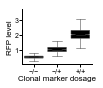

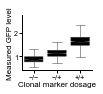

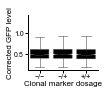

In [113]:
fig0 = compare(microscopy.data, 'rfp_measured', ylabel='RFP level')
fig1 = compare(microscopy.data, 'gfp_measured', ylabel='Measured GFP level')
fig2 = compare(microscopy.data, 'gfp_corrected', ylabel='Corrected GFP level')

#savefig(fig0, 'comparison_rfp')
#savefig(fig1, 'comparison_gfp')
#savefig(fig2, 'comparison_gfp_corrected')

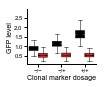

In [23]:
fig = compare(microscopy.data, ylabel='GFP level')

#savefig(fig, 'comparison_merged')

In [19]:
import seaborn as sns
import pandas as pd

plt.rcParams['axes.labelsize'] = 7
plt.rcParams['font.size'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6


def compare(data, xvar='true_dosage', ylabel='', **kwargs):
    
    df1 = deepcopy(data)
    df2 = deepcopy(data)
    df1['CORRECTED'] = False
    df1['COMPARED'] = df1['gfp_measured']
    df2['CORRECTED'] = True
    df2['COMPARED'] = df2['gfp_corrected']
    
    
    fig, ax = plt.subplots(figsize=(1.25, 1.))
    
    sns.boxplot(ax=ax,
        x='true_dosage',
        y='COMPARED',
        data=pd.concat((df1,df2)),
        order=(0, 1, 2),
        hue='CORRECTED',
        hue_order=(False, True),
        palette={False:'k', True:'r'},
        notch=True,
        width=0.8,
        linewidth=0.5,
        fliersize=0,
        **kwargs)

    # define labels and corresponding fill colors
    labels = {0:'−/−', 1:'−/+', 2:'+/+'}
    colors = {0:'k', 1:'k', 2:'k'}

    # format axes
    ax.grid(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    _ = ax.spines['top'].set_visible(False)
    _ = ax.spines['right'].set_visible(False)
    ax.get_legend().remove()
    ax.set_yticks([.5, 1., 1.5, 2., 2.5])

    # format xticks
    ticklabels = []
    for i, label in enumerate(ax.get_xticklabels()):

        # set violin/box color
        color = colors[int(label.get_text())]
        #ax.artists[i].set_facecolor(color)

        # set tick label as genotype
        label.set_text(labels[int(label.get_text())])
        ticklabels.append(label)

    # format xlabels
    ax.set_xlabel('Clonal marker dosage')
    ax.set_ylabel(ylabel)
    _ = ax.set_xticklabels(ticklabels, ha='center')

    return fig